# FNO for virtual damage sensor

In [1]:
# packages
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from pathlib import Path
from nopkit.data import load_damage_sensor_dataset
from nopkit.mask import MaskGenerator
# from nopkit.plot import data_image, pred_plot, pred_anim

# device = 'cuda'
device = 'cpu'
# torch.set_num_threads(2)

In [2]:
# load data
data_dir = Path("../data/damage_sensor")

train_loader, test_loaders, data_processor = load_damage_sensor_dataset(
    ramps_path=data_dir / "ramps_n500_res32.pt",
    damage_path=data_dir / "damage_n500_t175_res32.pt",
    defgrad_path=data_dir / "defgrad_n500_t175_res32.pt",
    elec_path=data_dir / "elec_n500_t175_res32.pt",
    # masks_path=data_dir / "masks5_range4_17.pt",
    masks_path=data_dir / "masks3_uniform.pt",
    n_train=450, # 450 out of 500
    batch_size=10,
    test_batch_sizes=[10],
    test_resolutions=[32],
    encode_input=True,
    encode_output=True,
    # encoding="channel-wise",
    # channel_dim=1,
)
data_processor = data_processor.to(device)

Loaded RAMPs      -> ..\data\damage_sensor\ramps_n500_res32.pt,	(torch.Size([500, 32, 32]))
Loaded damage     -> ..\data\damage_sensor\damage_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded defgrad    -> ..\data\damage_sensor\defgrad_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded elec field -> ..\data\damage_sensor\elec_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded masks      -> ..\data\damage_sensor\masks3_uniform.pt,	(torch.Size([3, 32, 32]))
Loading total samples: 500, total masks: 3
Loading train db: 450 samples, test db: 50 samples
Train input shape: torch.Size([450, 3, 32, 32, 175]), Train output shape: torch.Size([450, 3, 32, 32, 175])
Test input shape: torch.Size([50, 3, 32, 32, 175]), Test output shape: torch.Size([50, 3, 32, 32, 175])


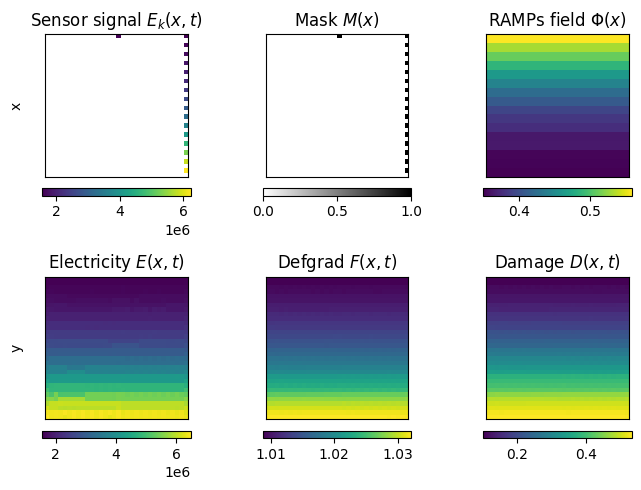

array([[<Axes: title={'center': 'Sensor signal $E_k(x, t)$'}>,
        <Axes: title={'center': 'Mask $M(x)$'}>,
        <Axes: title={'center': 'RAMPs field $\\Phi(x)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>]], dtype=object)

In [7]:
from nopkit.plot import data_image

# check train data
index = 2
x = train_loader.dataset[index]['x']
y = train_loader.dataset[index]['y']
data_image(x, y, t=174, show_colorbar=True)

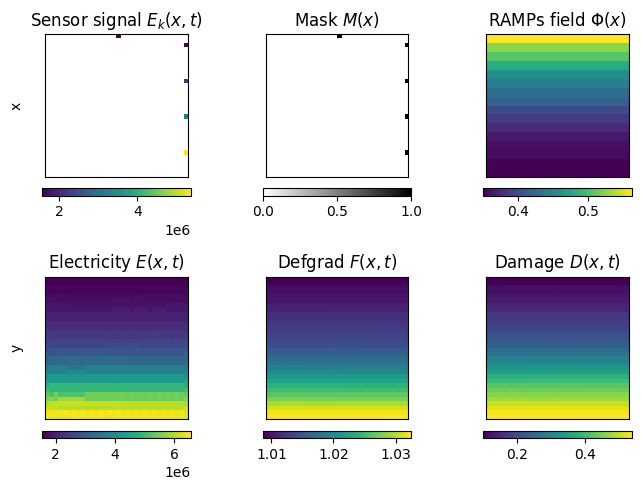

array([[<Axes: title={'center': 'Sensor signal $E_k(x, t)$'}>,
        <Axes: title={'center': 'Mask $M(x)$'}>,
        <Axes: title={'center': 'RAMPs field $\\Phi(x)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>]], dtype=object)

In [9]:
# check test data
index = 0
x = test_loaders[32].dataset[index]['x']
y = test_loaders[32].dataset[index]['y']
data_image(x, y, t=174, show_colorbar=True)

In [10]:
# config model
model = FNO(
    n_modes=(8,8,8),
    in_channels=3,
    out_channels=3,
    hidden_channels=64,
    n_layers=4,
    projection_channel_ratio=2,
    positional_embedding = 'grid',
    norm='group_norm',
    channel_mlp_dropout=0.1,
    channel_mlp_expansion=1.0,
    fno_skip='soft-gating',
    domain_padding=0.1,
    domain_padding_mode='symmetric',
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 10538691 parameters.


In [11]:
epochs=100
learning_rate=1e-4
scheduler_step=100
scheduler_gamma=0.5

# training setup
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate, # learning rate
    weight_decay=1e-4
)

# use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step, gamma=scheduler_gamma
)

# losses setup
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss # use H1 loss
eval_losses = {'h1': h1loss, 'l2':l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (domain_padding): DomainPadding()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 8, 8, 5]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (dropout): ModuleList(
          (0-1): 2 x Dropout(p=0.1, inplace=False)
        )
        (fcs): ModuleList(
          (0-1): 2 x Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
    (norm): ModuleList(
      (0-7): 8 x GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(6, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(


In [ ]:
# %%capture out
trainer = Trainer(
    model=model,
    n_epochs=epochs,
    data_processor=data_processor,
    device=device,
    mixed_precision=False,
    eval_interval=1,
    log_output=False,
    use_distributed=False,
    verbose=True,
    wandb_log = False
)

# train
trainer.train(
    train_loader=train_loader,
    test_loaders=test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=1,
    save_dir="./ckpt/fno3d_masks3_uniform/"
)

Training on 2250 samples
Testing on [250] samples         on resolutions [32].
Raw outputs of shape torch.Size([10, 3, 32, 32, 175])


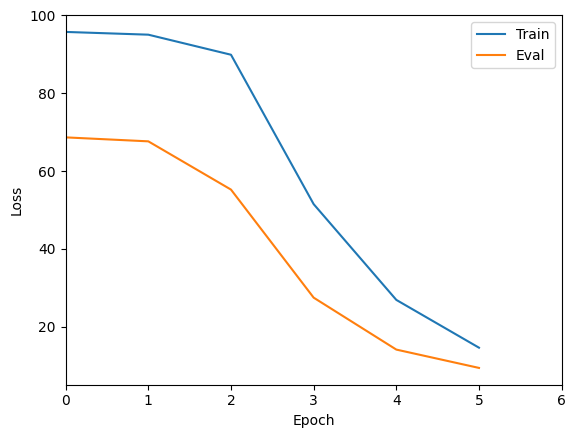

In [1]:
# plot train and eval loss
import re
import matplotlib.pyplot as plt

with open("log_masks5.txt", 'r') as f:
    log = f.read()

train_loss = [float(x) for x in re.findall(r"avg_loss=([0-9.]+)", log)]
eval_loss = [float(x) for x in re.findall(r"32_h1=([0-9.]+)", log)]

train_loss_rel = [x / train_loss[0] for x in train_loss]
eval_loss_rel = [x / eval_loss[0] for x in eval_loss]

# plot
fig, ax = plt.subplots()
ax.plot(train_loss, label='Train')
ax.plot(eval_loss, label='Eval')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set(xlim=[0, len(train_loss)], 
    #    ylim=[0, 1]
       )
ax.legend()
plt.show()

In [6]:
model.save_checkpoint("./model", save_name="fno3d_masks5")

In [7]:
# reload
model_reload = FNO.from_checkpoint("./model", save_name="fno3d_masks5")

array([[<Axes3D: title={'center': 'Electric Field'}>,
        <Axes3D: title={'center': 'Deformation Field'}>,
        <Axes3D: title={'center': 'Damage Indicator'}>],
       [<Axes3D: >, <Axes3D: >, <Axes3D: >]], dtype=object)

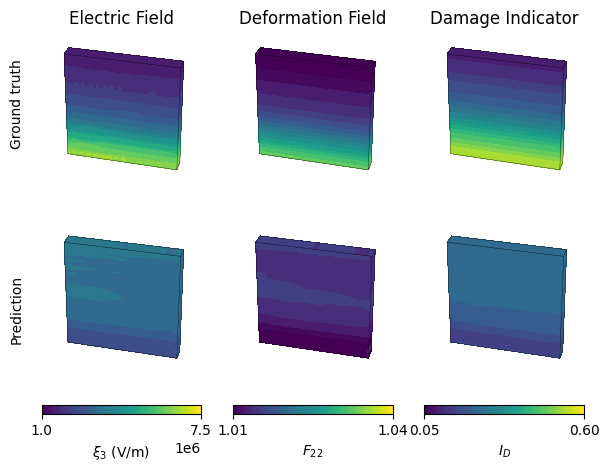

In [ ]:
# plot prediction
model_use = model
# model_use = model_reload.to(device)

test_samples = test_loaders[32].dataset
idx = 0

data = test_samples[idx]

data_processor.to(device)
data_processor.eval()
data = data_processor.preprocess(data, batched=True)


x = data['x']
y = data['y']
out = model_use(x)

# postprocess data
out, _ = data_processor.postprocess(out, data)

t = -1

vmins = [1e6, 1.01, 0.05]
vmaxs = [7.5e6, 1.04, 0.6]
pred_voxel(y.cpu(), out.squeeze().detach().cpu(), t=t,
           show_colorbar=True, vmins=vmins, vmaxs=vmaxs, plot_method='contourf', level=20, cmap='rainbow')